In [14]:
#https://www.wildcardconsulting.dk/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/

In [15]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [16]:
from deepchem.models import TensorGraph
from deepchem.models.tensorgraph import layers
from collections import Sequence
import numpy as np
import tensorflow as tf
import time
import deepchem as dc
from deepchem.data.datasets import NumpyDataset # import NumpyDataset

import numpy as np
import tensorflow as tf
import collections

from deepchem.metrics import to_one_hot

from deepchem.models.tensorgraph.tensor_graph import TensorGraph, TFWrapper
from deepchem.models.tensorgraph.layers import Feature, Label, Weights, \
    WeightedError, Dense, Dropout, WeightDecay, Reshape, SoftMax, SoftMaxCrossEntropy, \
    L2Loss, ReduceSum, Concat, Stack

In [17]:
def cmol_atombondhybridcharge(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            if (idx >= dims):
                return 0
            if (idy >= dims):
                return 0
            if (idx < 0):
                return 0
            if (idy < 0):
                return 0
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

In [18]:
#bonds
def get_bonds(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            if (idx >= dims):
                return 0
            if (idy >= dims):
                return 0
            if (idx < 0):
                return 0
            if (idy < 0):
                return 0
            vect[ idx , idy ] = bondorder
    return vect

In [19]:
#atoms
def get_atoms(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy] = atom.GetAtomicNum()
    return vect

In [20]:
#charge
def get_charge(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy] = charge
    return vect

In [21]:
#hybridization
def get_hybridization(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy] = hyptype
    return vect

In [22]:
#valence
def get_valence(mol, embed=15.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Valence
            valence = atom.GetTotalValence()
            vect[ idx, idy] = valence
    return vect

In [23]:
#maccs
from rdkit.Chem import MACCSkeys
def get_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

In [24]:
#fingerprint
n_features = 1024
ehiv_tasks, ehiv_datasets, ehiv_transformers = dc.molnet.load_hiv(featurizer='ECFP', split='scaffold', reload=True)
ehiv_train_dataset, ehiv_valid_dataset, ehiv_test_dataset = ehiv_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [25]:
n_features = 1024
hiv_tasks, hiv_datasets, hiv_transformers = dc.molnet.load_hiv(featurizer='Raw', split='scaffold', reload=True)
hiv_train_dataset, hiv_valid_dataset, hiv_test_dataset = hiv_datasets

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [26]:
print(hiv_train_dataset.X)

 <rdkit.Chem.rdchem.Mol object at 0x1a3d902110> ...


In [27]:
print(ehiv_train_dataset.X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]]


In [28]:
rdkit_train = hiv_train_dataset.X
rdkit_valid = hiv_valid_dataset.X
rdkit_test = hiv_test_dataset.X



(60, 60)


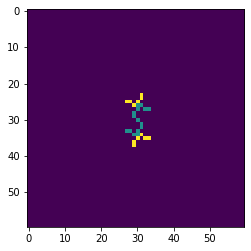

In [29]:
testing123 = get_bonds(rdkit_train[1])
print(testing123.shape)
plt.imshow(testing123)

#this shows the bonds: their strength and position

(60, 60)


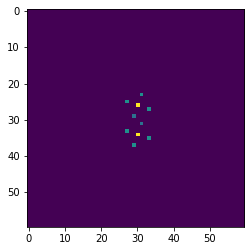

In [30]:
testing123 = get_atoms(rdkit_train[1])
print(testing123.shape)
plt.imshow(testing123)

#this shows the atoms by atomic number

(60, 60)


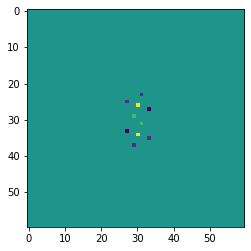

In [31]:
testing123 = get_charge(rdkit_train[1])
print(testing123.shape)
plt.imshow(testing123)

#this shows electrostatic partial charge, which plays into reactivity
#and structure of a molecule

(60, 60)


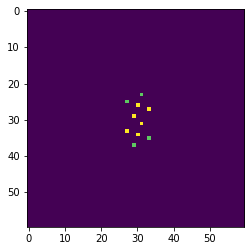

In [32]:
testing123 = get_hybridization(rdkit_train[1])
print(testing123.shape)
plt.imshow(testing123)

#has something to do with the molecular orbitals... don't know enough
#chem to understand

(60, 60)


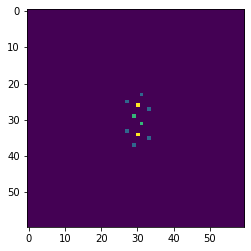

In [33]:
testing123 = get_valence(rdkit_train[1])
print(testing123.shape)
plt.imshow(testing123)

#electrons available for bonding or something? free electrons?

In [34]:
#alright now we're gonna make a whooooooole lotta datasets

train_bonds = []
train_atoms = []
train_valence = []
train_charge = []
train_hybridization = []
train_maccs = []
train_fingerprints = []

valid_bonds = []
valid_atoms = []
valid_valence = []
valid_charge = []
valid_hybridization = []
valid_maccs = []
valid_fingerprints = []

test_bonds = []
test_atoms = []
test_valence = []
test_charge = []
test_hybridization = []
test_maccs = []
test_fingerprints = []

trainfinger = ehiv_train_dataset.X
validfinger = ehiv_valid_dataset.X
testfinger = ehiv_test_dataset.X

trainy = hiv_train_dataset.y
validy = hiv_valid_dataset.y
testy = hiv_test_dataset.y

trainw = hiv_train_dataset.w
validw = hiv_valid_dataset.w
testw = hiv_test_dataset.w

trainids = hiv_train_dataset.ids
validids = hiv_valid_dataset.ids
testids = hiv_test_dataset.ids

train_y = []
valid_y = []
test_y = []

train_w = []
valid_w = []
test_w = []

train_ids = []
valid_ids = []
test_ids = []


In [35]:
for i in range(0, len(rdkit_train)):
    bonds = get_bonds(rdkit_train[i])
    if (type(bonds) is int):
        print("dropped")
        print(i)
    else:
        train_bonds.append(bonds)
        train_atoms.append(get_atoms(rdkit_train[i]))
        train_valence.append(get_valence(rdkit_train[i]))
        train_charge.append(get_charge(rdkit_train[i]))
        train_hybridization.append(get_hybridization(rdkit_train[i]))
        train_maccs.append(get_maccs(rdkit_train[i]))
        train_fingerprints.append(trainfinger[i])
        train_y.append(trainy[i])
        train_w.append(trainw[i])
        train_ids.append(trainids[i])
        

dropped
9
dropped
17
dropped
56
dropped
84
dropped
271
dropped
358
dropped
372
dropped
373
dropped
512
dropped
708
dropped
837
dropped
1086
dropped
1087
dropped
1088
dropped
1114
dropped
1183
dropped
1357
dropped
1358
dropped
1367
dropped
1539
dropped
1553
dropped
1563
dropped
1565
dropped
1631
dropped
1650
dropped
1850
dropped
1862
dropped
1881
dropped
1914
dropped
1953
dropped
1954
dropped
1955
dropped
1956
dropped
1983
dropped
1984
dropped
1990
dropped
1991
dropped
1992
dropped
1993
dropped
1994
dropped
1995
dropped
1996
dropped
1997
dropped
2181
dropped
2202
dropped
2231
dropped
2232
dropped
2500
dropped
2562
dropped
2563
dropped
2594
dropped
2595
dropped
2651
dropped
2898
dropped
2899
dropped
3101
dropped
3158
dropped
3277
dropped
3405
dropped
3406
dropped
3844
dropped
3845
dropped
3864
dropped
4156
dropped
4256
dropped
4331
dropped
4358
dropped
4359
dropped
4453
dropped
4466
dropped
4510
dropped
4579
dropped
4741
dropped
4848
dropped
5214
dropped
5283
dropped
5515
dropped
5579
dr

dropped
31381
dropped
31395
dropped
31406
dropped
31480
dropped
31521
dropped
31747
dropped
31748
dropped
31749
dropped
31750
dropped
31751
dropped
31790
dropped
31832
dropped
31833
dropped
31834
dropped
31835
dropped
31836
dropped
31838
dropped
31839
dropped
31840
dropped
31841
dropped
31842
dropped
31843
dropped
31844
dropped
31929
dropped
31930
dropped
31931
dropped
31932
dropped
32014
dropped
32118
dropped
32119
dropped
32120
dropped
32121
dropped
32122
dropped
32123
dropped
32124
dropped
32125
dropped
32129
dropped
32251
dropped
32252
dropped
32254
dropped
32402
dropped
32428
dropped
32485
dropped
32515
dropped
32517
dropped
32518
dropped
32519
dropped
32520
dropped
32521
dropped
32522
dropped
32550
dropped
32582
dropped
32583
dropped
32707
dropped
32717
dropped
32731
dropped
32732
dropped
32738
dropped
32740
dropped
32741
dropped
32748
dropped
32749
dropped
32759
dropped
32760
dropped
32761
dropped
32774
dropped
32801
dropped
32802
dropped
32803
dropped
32804
dropped
32805
droppe

In [36]:
for i in range(0, len(rdkit_valid)):
    bonds = get_bonds(rdkit_valid[i])
    if (type(bonds) is int):
        print("dropped")
        print(i)
    else:
        valid_bonds.append(bonds)
        valid_atoms.append(get_atoms(rdkit_valid[i]))
        valid_valence.append(get_valence(rdkit_valid[i]))
        valid_charge.append(get_charge(rdkit_valid[i]))
        valid_hybridization.append(get_hybridization(rdkit_valid[i]))
        valid_maccs.append(get_maccs(rdkit_valid[i]))
        valid_fingerprints.append(validfinger[i])
        valid_y.append(validy[i])
        valid_w.append(validw[i])
        valid_ids.append(validids[i])

dropped
47
dropped
116
dropped
120
dropped
185
dropped
201
dropped
202
dropped
203
dropped
211
dropped
275
dropped
276
dropped
281
dropped
687
dropped
688
dropped
780
dropped
781
dropped
802
dropped
805
dropped
842
dropped
869
dropped
900
dropped
909
dropped
1002
dropped
1003
dropped
1004
dropped
1085
dropped
1086
dropped
1126
dropped
1273
dropped
1333
dropped
1387
dropped
1440
dropped
1499
dropped
1522
dropped
1568
dropped
1640
dropped
1641
dropped
1657
dropped
1700
dropped
1807
dropped
1885
dropped
1933
dropped
1934
dropped
1935
dropped
1936
dropped
1973
dropped
1974
dropped
1976
dropped
1978
dropped
2007
dropped
2008
dropped
2053
dropped
2104
dropped
2105
dropped
2216
dropped
2244
dropped
2245
dropped
2266
dropped
2271
dropped
2319
dropped
2505
dropped
2559
dropped
2739
dropped
2740
dropped
2741
dropped
2786
dropped
2865
dropped
2866
dropped
2867
dropped
2955
dropped
2975
dropped
2985
dropped
2986
dropped
3014
dropped
3048
dropped
3057
dropped
3062
dropped
3063
dropped
3064
dropped


In [37]:
for i in range(0, len(rdkit_test)):
    bonds = get_bonds(rdkit_test[i])
    if (type(bonds) is int):
        print("dropped")
        print(i)
    else:
        test_bonds.append(bonds)
        test_atoms.append(get_atoms(rdkit_test[i]))
        test_valence.append(get_valence(rdkit_test[i]))
        test_charge.append(get_charge(rdkit_test[i]))
        test_hybridization.append(get_hybridization(rdkit_test[i]))
        test_maccs.append(get_maccs(rdkit_test[i]))
        test_fingerprints.append(testfinger[i])
        test_y.append(testy[i])
        test_w.append(testw[i])
        test_ids.append(testids[i])

dropped
80
dropped
148
dropped
392
dropped
397
dropped
445
dropped
453
dropped
465
dropped
467
dropped
468
dropped
470
dropped
600
dropped
612
dropped
627
dropped
631
dropped
737
dropped
739
dropped
740
dropped
741
dropped
742
dropped
768
dropped
769
dropped
783
dropped
906
dropped
937
dropped
947
dropped
948
dropped
949
dropped
950
dropped
951
dropped
956
dropped
969
dropped
977
dropped
1011
dropped
1120
dropped
1163
dropped
1189
dropped
1191
dropped
1192
dropped
1397
dropped
1400
dropped
1419
dropped
1479
dropped
1480
dropped
1559
dropped
1703
dropped
2407
dropped
2573
dropped
2614
dropped
2635
dropped
2681
dropped
2928
dropped
3045
dropped
3046
dropped
3047
dropped
3057
dropped
3062
dropped
3063
dropped
3093
dropped
3554
dropped
3557
dropped
3648
dropped
3724
dropped
3734
dropped
3737
dropped
3771
dropped
3772
dropped
3774
dropped
3778
dropped
3860
dropped
3861
dropped
3862
dropped
3863
dropped
3864
dropped
3971
dropped
3997
dropped
4035
dropped
4049
dropped
4082
dropped
4083
droppe

In [38]:
print(len(train_bonds))
print(len(train_ids))
print(len(rdkit_train))

32223
32223
32901


In [39]:
#alright so to list the possible featurizations...

#max number of added feats is 2, don't repeat any in augchemception paper

#maccs
#finger
#atoms/bonds

#atoms/bonds/charge
#atoms/bonds/valence
#atoms/bonds/hybrid
#atoms/bonds/maccs
#atoms/bonds/finger

#atoms/bonds/maccs/finger

In [40]:
print(train_bonds[0].shape)

(60, 60)


In [41]:
#creating atoms/bonds dataset
train_atoms_bonds = []
valid_atoms_bonds = []
test_atoms_bonds = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i]))
    train_atoms_bonds.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i]))
    valid_atoms_bonds.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i]))
    test_atoms_bonds.append(mol)

In [42]:
print(len(train_atoms_bonds))

32223


In [43]:
#maccs dataset already created

In [44]:
#fingerprint dataset already created
train_fingerprints = ehiv_train_dataset.X
valid_fingerprints = ehiv_valid_dataset.X
test_fingerprints = ehiv_test_dataset.X

In [45]:
#creating atoms/bonds/charge dataset
train_atoms_bonds_charge = []
valid_atoms_bonds_charge = []
test_atoms_bonds_charge = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i], train_charge[i]))
    train_atoms_bonds_charge.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i], valid_charge[i]))
    valid_atoms_bonds_charge.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i], test_charge[i]))
    test_atoms_bonds_charge.append(mol)

In [46]:
#creating atoms/bonds/valence dataset
train_atoms_bonds_valence = []
valid_atoms_bonds_valence = []
test_atoms_bonds_valence = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i], train_valence[i]))
    train_atoms_bonds_valence.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i], valid_valence[i]))
    valid_atoms_bonds_valence.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i], test_valence[i]))
    test_atoms_bonds_valence.append(mol)

In [47]:
#creating atoms/bonds/hybrid dataset
train_atoms_bonds_hybridization = []
valid_atoms_bonds_hybridization = []
test_atoms_bonds_hybridization = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i], train_hybridization[i]))
    train_atoms_bonds_hybridization.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i], valid_hybridization[i]))
    valid_atoms_bonds_hybridization.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i], test_hybridization[i]))
    test_atoms_bonds_hybridization.append(mol)

In [48]:
#creating atoms/bonds/hybrid dataset
train_atoms_bonds_hybridization = []
valid_atoms_bonds_hybridization = []
test_atoms_bonds_hybridization = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i], train_hybridization[i]))
    train_atoms_bonds_hybridization.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i], valid_hybridization[i]))
    valid_atoms_bonds_hybridization.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i], test_hybridization[i]))
    test_atoms_bonds_hybridization.append(mol)

In [49]:
print(train_atoms_bonds[0].shape)

(120, 60)


In [50]:
#creating atoms/bonds/maccs dataset
train_atoms_bonds_maccs = []
valid_atoms_bonds_maccs = []
test_atoms_bonds_maccs = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i]))
    maccs = train_maccs[i]
    zero = np.zeros(13)
    maccs = np.concatenate((maccs, zero))
    maccs = np.reshape(maccs, (3, 60))
    mol = np.concatenate((mol, maccs))
    train_atoms_bonds_maccs.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i]))
    maccs = valid_maccs[i]
    zero = np.zeros(13)
    maccs = np.concatenate((maccs, zero))
    maccs = np.reshape(maccs, (3, 60))
    mol = np.concatenate((mol, maccs))
    valid_atoms_bonds_maccs.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i]))
    maccs = test_maccs[i]
    zero = np.zeros(13)
    maccs = np.concatenate((maccs, zero))
    maccs = np.reshape(maccs, (3, 60))
    mol = np.concatenate((mol, maccs))    
    test_atoms_bonds_maccs.append(mol)

In [51]:
#creating atoms/bonds/fingerprints dataset
train_atoms_bonds_fingerprints = []
valid_atoms_bonds_fingerprints = []
test_atoms_bonds_fingerprints = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i]))
    finger = train_fingerprints[i]
    zero = np.zeros(56)
    finger = np.concatenate((finger, zero))
    finger = np.reshape(finger, (18, 60))
    mol = np.concatenate((mol, finger))    
    train_atoms_bonds_fingerprints.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i]))
    finger = valid_fingerprints[i]
    zero = np.zeros(56)
    finger = np.concatenate((finger, zero))
    finger = np.reshape(finger, (18, 60))
    mol = np.concatenate((mol, finger)) 
    valid_atoms_bonds_fingerprints.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i]))
    finger = test_fingerprints[i]
    zero = np.zeros(56)
    finger = np.concatenate((finger, zero))
    finger = np.reshape(finger, (18, 60))
    mol = np.concatenate((mol, finger))   
    test_atoms_bonds_fingerprints.append(mol)

In [52]:
#creating atoms/bonds/finger/maccs dataset
train_atoms_bonds_fingerprints_maccs = []
valid_atoms_bonds_fingerprints_maccs = []
test_atoms_bonds_fingerprints_maccs = []
for i in range(0, len(train_bonds)):
    mol = np.concatenate((train_bonds[i], train_atoms[i]))
    fingermaccs = np.concatenate((train_fingerprints[i], train_maccs[i]))
    zero = np.zeros(9)
    fingermaccs = np.concatenate((fingermaccs, zero))
    fingermaccs = np.reshape(fingermaccs, (20, 60))
    mol = np.concatenate((mol, fingermaccs))   
    train_atoms_bonds_fingerprints_maccs.append(mol)
for i in range(0, len(valid_bonds)):
    mol = np.concatenate((valid_bonds[i], valid_atoms[i]))
    fingermaccs = np.concatenate((valid_fingerprints[i], valid_maccs[i]))
    zero = np.zeros(9)
    fingermaccs = np.concatenate((fingermaccs, zero))
    fingermaccs = np.reshape(fingermaccs, (20, 60))
    mol = np.concatenate((mol, fingermaccs))  
    valid_atoms_bonds_fingerprints_maccs.append(mol)
for i in range(0, len(test_bonds)):
    mol = np.concatenate((test_bonds[i], test_atoms[i]))
    fingermaccs = np.concatenate((test_fingerprints[i], test_maccs[i]))
    zero = np.zeros(9)
    fingermaccs = np.concatenate((fingermaccs, zero))
    fingermaccs = np.reshape(fingermaccs, (20, 60))
    mol = np.concatenate((mol, fingermaccs))  
    test_atoms_bonds_fingerprints_maccs.append(mol)

In [53]:
#creating atoms/bonds/finger/maccs dataset
train_fingerprints_maccs = []
valid_fingerprints_maccs = []
test_fingerprints_maccs = []
for i in range(0, len(train_bonds)):
    fingermaccs = np.concatenate((train_fingerprints[i], train_maccs[i]))
    train_fingerprints_maccs.append(fingermaccs)
for i in range(0, len(valid_bonds)):
    fingermaccs = np.concatenate((valid_fingerprints[i], valid_maccs[i]))
    valid_fingerprints_maccs.append(fingermaccs)
for i in range(0, len(test_bonds)):
    fingermaccs = np.concatenate((test_fingerprints[i], test_maccs[i]))
    test_fingerprints_maccs.append(fingermaccs)

In [54]:
print(len(train_fingerprints_maccs))

32223


In [55]:
print(len(train_atoms_bonds))

32223


In [56]:
print(train_atoms_bonds_fingerprints_maccs[0].shape)

(140, 60)


In [57]:
#left to do...

#make dataset objects so that the deepchem stuff will actually work
#then just run models I guess

In [58]:
hiv_train_dataset.get_shape

<bound method DiskDataset.get_shape of <deepchem.data.datasets.DiskDataset object at 0x1a49bb72e8>>

In [59]:
#maccs
final_train_maccs = dc.data.NumpyDataset(train_maccs, train_y, train_w, train_ids)
final_valid_maccs = dc.data.NumpyDataset(valid_maccs, valid_y, valid_w, valid_ids)
final_test_maccs = dc.data.NumpyDataset(test_maccs, test_y, test_w, test_ids)


In [60]:
#fingerprints
final_train_fingerprints = dc.data.NumpyDataset(train_fingerprints, train_y, train_w, train_ids)
final_valid_fingerprints = dc.data.NumpyDataset(valid_fingerprints, valid_y, valid_w, valid_ids)
final_test_fingerprints = dc.data.NumpyDataset(test_fingerprints, test_y, test_w, test_ids)


In [61]:
#atombonds
final_train_atomsbonds = dc.data.NumpyDataset(train_atoms_bonds, train_y, train_w, train_ids)
final_valid_atomsbonds = dc.data.NumpyDataset(valid_atoms_bonds, valid_y, valid_w, valid_ids)
final_test_atomsbonds = dc.data.NumpyDataset(test_atoms_bonds, test_y, test_w, test_ids)


In [62]:
#atombondscharge
final_train_atomsbondscharge = dc.data.NumpyDataset(train_atoms_bonds_charge, train_y, train_w, train_ids)
final_valid_atomsbondscharge = dc.data.NumpyDataset(valid_atoms_bonds_charge, valid_y, valid_w, valid_ids)
final_test_atomsbondscharge = dc.data.NumpyDataset(test_atoms_bonds_charge, test_y, test_w, test_ids)


In [63]:
#atombondsvalence
final_train_atomsbondsvalence = dc.data.NumpyDataset(train_atoms_bonds_valence, train_y, train_w, train_ids)
final_valid_atomsbondsvalence = dc.data.NumpyDataset(valid_atoms_bonds_valence, valid_y, valid_w, valid_ids)
final_test_atomsbondsvalence = dc.data.NumpyDataset(test_atoms_bonds_valence, test_y, test_w, test_ids)


In [64]:
#atombondshybrid
final_train_atomsbondshybrid = dc.data.NumpyDataset(train_atoms_bonds_hybridization, train_y, train_w, train_ids)
final_valid_atomsbondshybrid = dc.data.NumpyDataset(valid_atoms_bonds_hybridization, valid_y, valid_w, valid_ids)
final_test_atomsbondshybrid = dc.data.NumpyDataset(test_atoms_bonds_hybridization, test_y, test_w, test_ids)


In [65]:
#atombondsmaccs
final_train_atomsbondsmaccs = dc.data.NumpyDataset(train_atoms_bonds_maccs, train_y, train_w, train_ids)
final_valid_atomsbondsmaccs = dc.data.NumpyDataset(valid_atoms_bonds_maccs, valid_y, valid_w, valid_ids)
final_test_atomsbondsmaccs = dc.data.NumpyDataset(test_atoms_bonds_maccs, test_y, test_w, test_ids)


In [66]:
#atombondsfingerprints
final_train_atomsbondsfinger = dc.data.NumpyDataset(train_atoms_bonds_hybridization, train_y, train_w, train_ids)
final_valid_atomsbondsfinger = dc.data.NumpyDataset(valid_atoms_bonds_hybridization, valid_y, valid_w, valid_ids)
final_test_atomsbondsfinger = dc.data.NumpyDataset(test_atoms_bonds_hybridization, test_y, test_w, test_ids)


In [67]:
#atombondsmaccsfingerprints
final_train_atomsbondsmaccsfinger = dc.data.NumpyDataset(train_atoms_bonds_fingerprints_maccs, train_y, train_w, train_ids)
final_valid_atomsbondsmaccsfinger = dc.data.NumpyDataset(valid_atoms_bonds_fingerprints_maccs, valid_y, valid_w, valid_ids)
final_test_atomsbondsmaccsfinger = dc.data.NumpyDataset(test_atoms_bonds_fingerprints_maccs, test_y, test_w, test_ids)


In [68]:
#maccsfingerprints
final_train_maccsfinger = dc.data.NumpyDataset(train_fingerprints_maccs, train_y, train_w, train_ids)
final_valid_maccsfinger = dc.data.NumpyDataset(valid_fingerprints_maccs, valid_y, valid_w, valid_ids)
final_test_maccsfinger = dc.data.NumpyDataset(test_fingerprints_maccs, test_y, test_w, test_ids)


In [69]:
print(final_train_maccs.X.shape)

(32223, 167)


In [70]:
print(final_train_maccsfinger.X.shape)

(32223, 1191)


In [71]:
#maccs
multitask_model = dc.models.MultitaskClassifier(
    1,
    167,
    layer_sizes=[1000],
    dropouts=[.25],
    learning_rate=0.001,
    batch_size=32)
multitask_model.fit(final_train_maccs)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


26.483124202405904

In [72]:
print("Evaluating model")
train_scores = multitask_model.evaluate(final_train_maccs, [metric], hiv_transformers)
valid_scores = multitask_model.evaluate(final_valid_maccs, [metric], hiv_transformers)
test_scores = multitask_model.evaluate(final_test_maccs, [metric], hiv_transformers)

print("HIV Train scores")
print(train_scores)

print("HIV Validation scores")
print(valid_scores)    
    
print("HIV Test scores")
print(test_scores)

Evaluating model
computed_metrics: [0.9352579155558443]
computed_metrics: [0.7811390157280569]
computed_metrics: [0.7038162509692759]
HIV Train scores
{'mean-roc_auc_score': 0.9352579155558443}
HIV Validation scores
{'mean-roc_auc_score': 0.7811390157280569}
HIV Test scores
{'mean-roc_auc_score': 0.7038162509692759}


In [73]:
#ecfp
n_features = 1024
multitask_model2 = dc.models.MultitaskClassifier(
    1,
    n_features,
    layer_sizes=[1000],
    dropouts=[.25],
    learning_rate=0.001,
    batch_size=64)
multitask_model2.fit(ehiv_train_dataset)

13.364058635388778

In [74]:
print("Evaluating model")
train_scores = multitask_model2.evaluate(ehiv_train_dataset, [metric], hiv_transformers)
valid_scores = multitask_model2.evaluate(ehiv_valid_dataset, [metric], hiv_transformers)
test_scores = multitask_model2.evaluate(ehiv_test_dataset, [metric], hiv_transformers)

print("HIV Train scores")
print(train_scores)

print("HIV Validation scores")
print(valid_scores)    
    
print("HIV Test scores")
print(test_scores)

Evaluating model
computed_metrics: [0.9936733985014637]
computed_metrics: [0.7705011145404663]
computed_metrics: [0.7508367291759207]
HIV Train scores
{'mean-roc_auc_score': 0.9936733985014637}
HIV Validation scores
{'mean-roc_auc_score': 0.7705011145404663}
HIV Test scores
{'mean-roc_auc_score': 0.7508367291759207}


In [75]:
n_features = 1024
multitask_model3 = dc.models.MultitaskClassifier(
    1,
    1191,
    layer_sizes=[1500],
    dropouts=[.25],
    learning_rate=0.001,
    batch_size=64)
multitask_model3.fit(final_train_maccsfinger)

9.034507039843536

In [76]:
print("Evaluating model")
train_scores = multitask_model3.evaluate(final_train_maccsfinger, [metric], hiv_transformers)
valid_scores = multitask_model3.evaluate(final_valid_maccsfinger, [metric], hiv_transformers)
test_scores = multitask_model3.evaluate(final_test_maccsfinger, [metric], hiv_transformers)

print("HIV Train scores")
print(train_scores)

print("HIV Validation scores")
print(valid_scores)    
    
print("HIV Test scores")
print(test_scores)

Evaluating model
computed_metrics: [0.99907887826307]
computed_metrics: [0.5783779576587795]
computed_metrics: [0.6271689954963975]
HIV Train scores
{'mean-roc_auc_score': 0.99907887826307}
HIV Validation scores
{'mean-roc_auc_score': 0.5783779576587795}
HIV Test scores
{'mean-roc_auc_score': 0.6271689954963975}


In [77]:
#create a fairly high-layered graph (5+) of conv2d layers, use the same settings as 
#the paper, tune until you get the same result

In [78]:
#need to fix this up and optimize it, so tiring

In [79]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

RDKit: 2019.03.2
Keras: 2.2.4


Using TensorFlow backend.


In [80]:
input_shape = np.reshape(train_atoms_bonds[0], (72, 100, 1)).shape
input_img = train_atoms_bonds[0]
print(input_shape)

(72, 100, 1)


In [81]:

np.save("/Users/danieldemarchi/Desktop/atombondstrainx", train_atoms_bonds)
np.save("/Users/danieldemarchi/Desktop/atombondstestx", test_atoms_bonds)

np.save("/Users/danieldemarchi/Desktop/atombondschargetrainx", train_atoms_bonds_charge)
np.save("/Users/danieldemarchi/Desktop/atombondschargetestx", test_atoms_bonds_charge)

np.save("/Users/danieldemarchi/Desktop/atombondsvalencetrainx", train_atoms_bonds_valence)
np.save("/Users/danieldemarchi/Desktop/atombondsvalencetestx", test_atoms_bonds_valence)

np.save("/Users/danieldemarchi/Desktop/atombondshybridizationtrainx", train_atoms_bonds_hybridization)
np.save("/Users/danieldemarchi/Desktop/atombondshybridizationtestx", test_atoms_bonds_hybridization)

np.save("/Users/danieldemarchi/Desktop/atombondsmaccstrainx", train_atoms_bonds_maccs)
np.save("/Users/danieldemarchi/Desktop/atombondsmaccstestx", test_atoms_bonds_maccs)

np.save("/Users/danieldemarchi/Desktop/atombondsfingertrainx", train_atoms_bonds_fingerprints)
np.save("/Users/danieldemarchi/Desktop/atombondsfingertestx", test_atoms_bonds_fingerprints)

np.save("/Users/danieldemarchi/Desktop/atombondsfingermaccstrainx", train_atoms_bonds_fingerprints_maccs)
np.save("/Users/danieldemarchi/Desktop/atombondsfingermaccstestx", test_atoms_bonds_fingerprints_maccs)


In [82]:
np.save("/Users/danieldemarchi/Desktop/atombondstrainx", train_atoms_bonds)
np.save("/Users/danieldemarchi/Desktop/atombondstestx", test_atoms_bonds)

In [83]:
print(train_atoms_bonds_fingerprints_maccs[0].shape)

(140, 60)


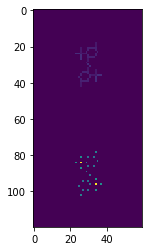

In [84]:
plt.imshow(train_atoms_bonds[0])

In [85]:
trainx = np.array(hiv_train_dataset.X)
trainy = np.array(hiv_train_dataset.y)
validx = np.array(hiv_valid_dataset.X)
validy = np.array(hiv_valid_dataset.y)
testx = np.array(hiv_test_dataset.X)
testy = np.array(hiv_test_dataset.y)

In [86]:
x = np.concatenate((trainx, validx, testx))
print(x.shape)

(41127,)


In [87]:
y = np.concatenate((trainy, validy, testy))
print(y.shape)

(41127, 1)


In [88]:
print(x[0])

In [89]:
np.save("/Users/danieldemarchi/Desktop/testingx", x)
np.save("/Users/danieldemarchi/Desktop/testingy", y)
